In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dat = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/Bellamite_538_R.nc')

In [3]:
display(dat)

<xarray.Dataset> Size: 65MB
Dimensions:                                   (N_MEASUREMENTS: 415541,
                                               N_PARAM: 16)
Dimensions without coordinates: N_MEASUREMENTS, N_PARAM
Data variables: (12/51)
    TIME                                      (N_MEASUREMENTS) datetime64[ns] 3MB ...
    TIME_GPS                                  (N_MEASUREMENTS) datetime64[ns] 3MB ...
    PHASE                                     (N_MEASUREMENTS) float32 2MB ...
    PHASE_QC                                  (N_MEASUREMENTS) float32 2MB ...
    LATITUDE_GPS                              (N_MEASUREMENTS) float32 2MB ...
    LONGITUDE_GPS                             (N_MEASUREMENTS) float32 2MB ...
    ...                                        ...
    PLATFORM_TYPE                             <U6 24B ...
    PLATFORM_MODEL                            <U2 8B ...
    WMO_IDENTIFIER                            <U3 12B ...
    DEPLOYMENT_TIME                           datetime64[ns] 8B ...
    DEPLOYMENT_LATITUDE                       <U3 12B ...
    DEPLOYMENT_LONGITUDE                      <U3 12B ...
Attributes: (12/68)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_min:              -54.43104
    geospatial_lat_max:              50.89405
    geospatial_lon_min:              -89.29212
    geospatial_lon_max:              -1.3952867
    ...                              ...
    instrument:                      ['Slocum G1+G2 Glider Navigation data lo...
    metadata_link:                   https://api.linked-systems.uk/api/meta/v...
    trajectory:                      Bellamite_20191206
    date_created:                    2024-04-08T15:08:06.115623
    date_modified:                   2024-04-08T15:08:06.115635
    id:                              Bellamite_20191206T000000_R

In [6]:
df_full = dat[['CHLA', 'PRES', 'BBP700', 'TIME']].to_dataframe()
df = df_full.dropna(subset = ['CHLA', 'PRES', 'BBP700'] ,how = 'all')

df['PRES'] = df['PRES'].interpolate()

C:\Users\flapet\AppData\Local\Temp\ipykernel_22340\3723142933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRES'] = df['PRES'].interpolate()


In [7]:
df_full.shape[0]

415541

In [18]:
df_full[1000:2000]

,CHLA,PRES,BBP700,TIME,LATITUDE,LONGITUDE,PHASE
N_MEASUREMENTS,,,,,,,
3410,0.5916,NaN,0.000143,2019-12-06 12:38:12.414673152,NaN,NaN,NaN
3414,0.5984,NaN,0.000139,2019-12-06 12:38:22.723357952,NaN,NaN,NaN
3418,0.5372,NaN,0.000137,2019-12-06 12:38:32.890472192,NaN,NaN,NaN
3422,0.5440,NaN,0.000118,2019-12-06 12:38:42.980652032,NaN,NaN,NaN
3427,0.5304,NaN,0.000156,2019-12-06 12:38:53.148224000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7222,0.7752,NaN,0.000274,2019-12-06 15:27:30.653290240,NaN,NaN,NaN
7228,0.8092,NaN,0.000196,2019-12-06 15:27:40.778107136,NaN,NaN,NaN
7232,0.8432,NaN,0.000192,2019-12-06 15:27:51.041137408,NaN,NaN,NaN


In [19]:
df_full[1000:2000].to_csv('test.csv')

Text(0.5, 0, 'Chla concentration')

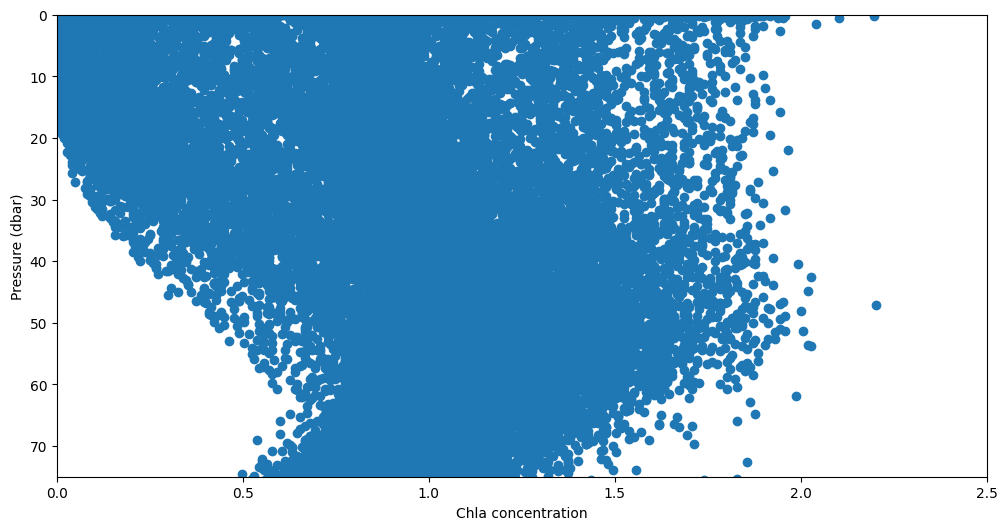

In [8]:
plt.figure(figsize=(12,6))
plt.scatter(df['CHLA'], df['PRES'])
plt.ylim([0,75])
plt.xlim([0,2.5])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Chla concentration')

Text(0.5, 0, 'Chla concentration')

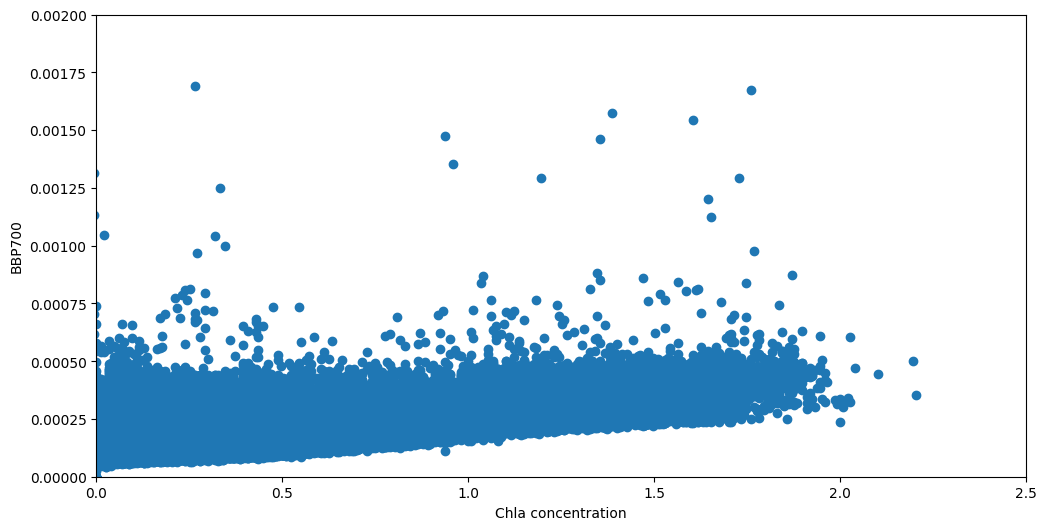

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(df['CHLA'], df['BBP700'])
plt.xlim([0,2.5])
plt.ylim([0,0.002])
plt.ylabel('BBP700')
plt.xlabel('Chla concentration')

In [10]:
df.set_index('TIME', inplace=True)

Text(0.5, 0, 'Time')

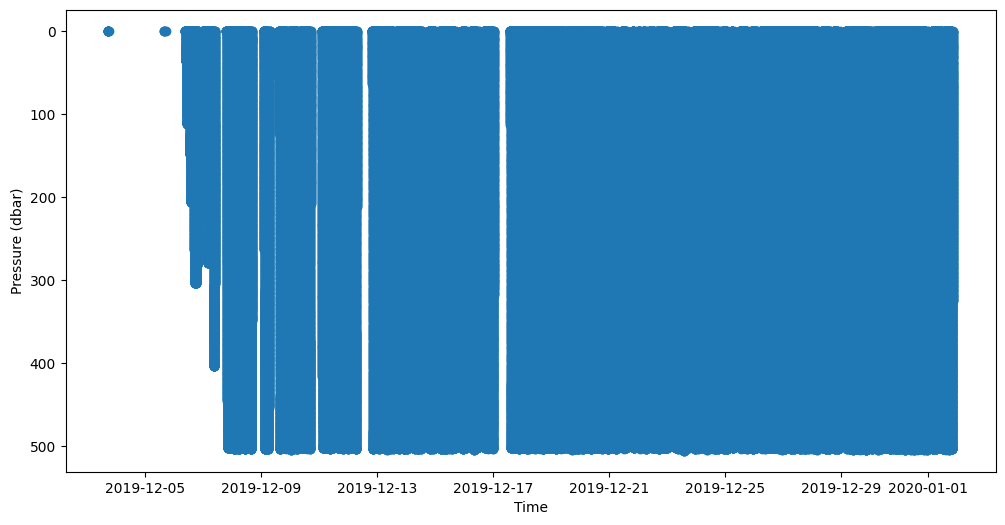

In [11]:
plt.figure(figsize=(12,6))
plt.scatter(x = df.index, y = df['PRES'])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

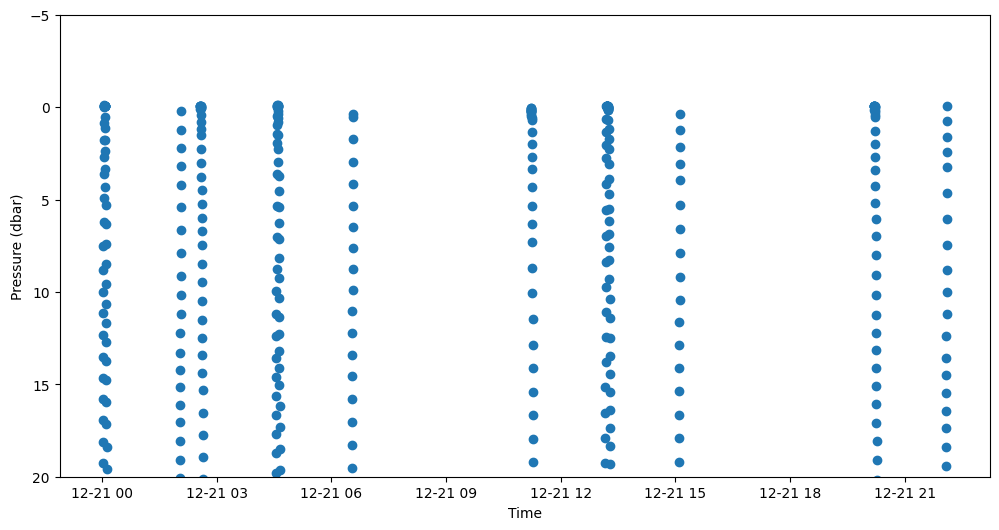

In [12]:
df1 = df.loc['2019-12-21':'2019-12-21']
plt.figure(figsize=(12,6))
plt.scatter(x = df1.index, y = df1['PRES'])
plt.ylim([-5,20])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')

In [13]:
df_full['PRES'] = df_full['PRES'].interpolate()

df_full.set_index('TIME', inplace=True)


In [14]:
df_full = df_full[df_full['LONGITUDE'] < -88]
plt.figure(figsize=(12,6))
plt.scatter(x = df_full['LONGITUDE'], y = df_full['LATITUDE'], c=df_full['PRES'], cmap='viridis')
cbar = plt.colorbar(label='Index')
cbar.set_label('Pressure (dB)', rotation=270, labelpad=15)

KeyError: 'LONGITUDE'

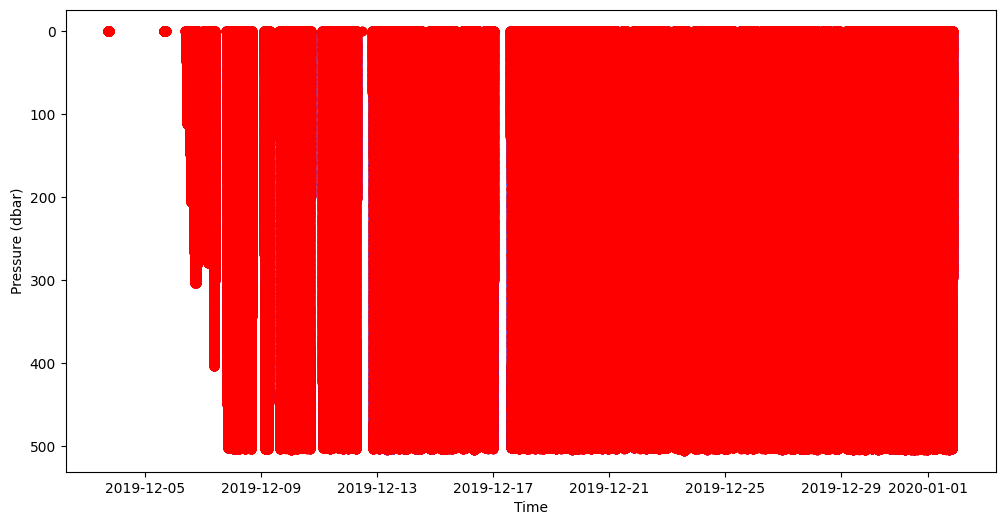

In [15]:
# Separate data into two groups based on NA values in the third variable
na_mask = df_full['CHLA'].isna()
df_na = df_full[na_mask]
df_not_na = df_full[~na_mask]

plt.figure(figsize = (12,6))
# Create scatter plots
plt.scatter(df_not_na.index, df_not_na['PRES'], color='blue', label='Not NA')
plt.scatter(df_na.index, df_na['PRES'], color='red', label='NA')

# Label axes and add legend
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')

# Show plot
plt.show()

In [26]:
# Create an initial profile value
profile = 1

# Create an empty list to store profile values
profile_values = []

# Initialize the previous pressure value
prev_pres = 0
prev_way = None

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    #Compute the difference of pressure
    diff = pres - prev_pres
    if diff < 0:
        way = 'asc'
    else:
        way = 'desc'
    if prev_way is None or way == prev_way:
        profile_values.append(profile)
    else:
        profile += 1
        profile_values.append(profile)
    # Update the previous pressure value
    prev_pres = pres
    prev_way = way

# Add the profile values to the DataFrame
df['profile'] = profile_values

C:\Users\flapet\AppData\Local\Temp\ipykernel_22340\25616829.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profile'] = profile_values


Text(0.5, 0, 'Time')

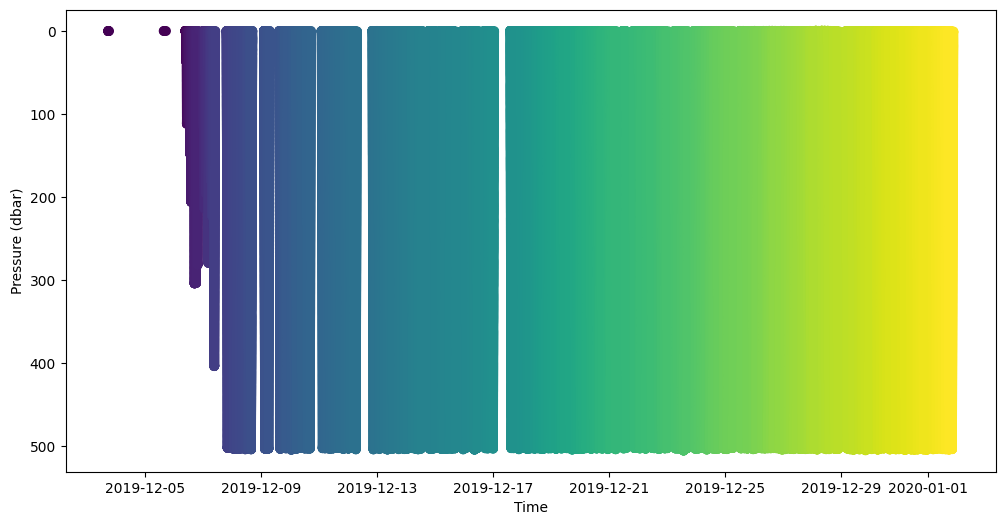

In [27]:
plt.figure(figsize=(12,6))
plt.scatter(x = df.index, y = df['PRES'], c = df['profile'], cmap= 'viridis')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')

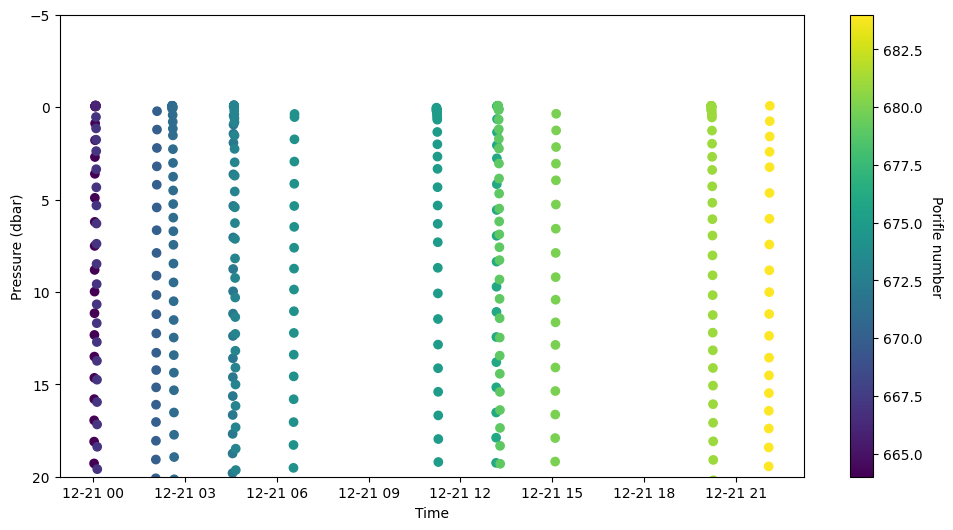

In [28]:
df1 = df.loc['2019-12-21':'2019-12-21']
plt.figure(figsize=(12,6))
plt.scatter(x = df1.index, y = df1['PRES'], c = df1['profile'])
plt.ylim([-5,20])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Porifle number', rotation=270, labelpad=15)

,CHLA,PRES,BBP700,profile
TIME,,,,
2019-12-21 00:00:04.793304064,0.9316,29.934999,0.000249,664
2019-12-21 00:00:15.140625152,0.8976,28.912498,0.000251,664
2019-12-21 00:00:21.236938496,NaN,27.889999,NaN,664
2019-12-21 00:00:25.373778688,0.8296,26.622499,0.000234,664
2019-12-21 00:00:35.513153536,0.8772,25.355000,0.000249,664
